In [5]:
from Bio import Phylo, AlignIO
from io import StringIO
from Bio.Phylo.TreeConstruction import ParsimonyScorer, NNITreeSearcher, ParsimonyTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

## Ejercicio 3.1: UPGMA a mano a partir del FASTA

Para poder realizar el ejercicio, cabe destacar que UPGMA necesita que las secuencias estén alineadas para poder contar diferencias posición a posición. En el FASTA que se nos ha proporcionado, ya aparecen con guiones, por lo que se interpreta que el alineamiento ya está hecho.

Sin embargo, _Homo Sapiens_ aparece con 22 caracteres, y el resto de secuencias tiene 23. Para poder hacer bien la comparación, asumimos que a _Homo Sapiens_ le falta el último carácter y añadimos un guion al final para igualar longitudes (ATGCTAGCTAGCTACG--TACG-).

Ahora, contamos diferencias (Hamming): misma letra = 0, letra distinta = +1, y tratamos el guion como un carácter más (gap vs nucleótido cuenta como diferencia; gap vs gap no cuenta).

### Paso 1. Matriz de distancias (tabla de diferencias)

Para abreviar, las llamamos de la siguiente manera:
- H = Homo_sapiens
- P = Pan_troglodytes
- G = Gorilla_gorilla
- O = Pongo_abelii
- M = Macaca_mulatta

Contando diferencias posición a posición, salen:
- d(H,P)=1
- d(H,G)=2
- d(H,O)=5
- d(H,M)=8
- d(P,G)=1
- d(P,O)=4
- d(P,M)=7
- d(G,O)=3
- d(G,M)=6
- d(O,M)=4

La matriz simétrica queda de la siguiente forma:

|        | C1=(H,P) | G   | O   | M   |
| ------ | -------- | --- | --- | --- |
| **C1** | 0        | 1.5 | 4.5 | 7.5 |
| **G**  | 1.5      | 0   | 3   | 6   |
| **O**  | 4.5      | 3   | 0   | 4   |
| **M**  | 7.5      | 6   | 4   | 0   |

### Paso 2. Buscar la distancia mínima y agrupar

La distancia mínima es 1, y aparece en dos pares:
- (H, P) 
- (P, G) 

Aquí hay empate, y UPGMA permite elegir cualquiera. En este caso, se ha elegido (H,P) por su sentido biológico (humano y chimpancé muy cercanos).

 Por lo tanto, el primer cluster es: 
 - C1 = (H,P) con distancia 1.

En UPGMA, la altura del nodo (tiempo/distancia ultramétrica) es:

$$
h(C1) = \frac{d(H, P)}{2} = \frac{1}{2} = 0.5
$$

### Paso 3. Recalcular distancias por promedio (UPGMA)

La distancia entre un cluster y otra secuencia se calcula como promedio aritmético de las distancias de sus miembros. Las distancias desde C1=(H,P) al resto son:

- d(C1, G) = (d(H,G)+d(P,G))/2 = (2+1)/2 = 1.5
- d(C1, O) = (5+4)/2 = 4.5
- d(C1, M) = (8+7)/2 = 7.5

Por lo tanto, la nueva tabla es:

|        | C1=(H,P) | G   | O   | M   |
| ------ | -------- | --- | --- | --- |
| **C1** | 0        | 1.5 | 4.5 | 7.5 |
| **G**  | 1.5      | 0   | 3   | 6   |
| **O**  | 4.5      | 3   | 0   | 4   |
| **M**  | 7.5      | 6   | 4   | 0   |

Ahora, la mínima es 1.5, así que se agrupa:

*Segundo cluster:* C2 = (G, C1) = (G,(H,P)) con distancia 1.5. 

La altura es:

$$
h(C2) = \frac{1.5}{2} = 0.75
$$

### Paso 4. Recalcular de nuevo

Ahora, se tienen tres "unidades": C2, O, M.

Las distancias son:
- d(C2, O) = promedio entre (G,O), (H,O), (P,O)
$$
d(C2, O) = \frac{3 + 5 + 4}{3} = 4.0
$$
- d(C2, M) = promedio entre (G,M), (H,M), (P,M)
$$
d(C2, M) = \frac{6 + 8 + 7}{3} = 7.0
$$
- d(O,M)=4 (ya se tenía)

La tabla resultante es:

|        | C2=(G,H,P) | O   | M   |
| ------ | ---------- | --- | --- |
| **C2** | 0          | 4.0 | 7.0 |
| **O**  | 4.0        | 0   | 4   |
| **M**  | 7.0        | 4   | 0   |

*Mínima:* 4. Hay de nuevo un empate, esta vez entre C2-O y O-M. Como hay que elegir de nuevo, optamos por agrupar las que claramente son más próximas entre sí en esta matriz, o sea, (O,M).

*Tercer cluster:* C3 = (O,M) con distancia 4

Altura:

$$
h(C3) = \frac{4}{2} = 2.0
$$

### Paso 5. Fusión final

Los cluster resultantes son C2 y C3. La distancia entre clusters es el promedio de todas las distancias cruzadas -> C2 = {G,H,P} y C3 = {O,M}

$$
d(C2, C3) =
\frac{
d(G, O) + d(G, M) + d(H, O) + d(H, M) + d(P, O) + d(P, M)
}{6}
$$

Sustituyendo:

$$
d(C2, C3) =
\frac{3 + 6 + 5 + 8 + 4 + 7}{6}
= \frac{33}{6}
= 5.5
$$

Altura final (raíz):

$$
h(\text{root}) = \frac{5.5}{2} = 2.75
$$

## Árbol resultante y longitudes de ramas

Para obtener las longitudes de rama, se restan las alturas:

- H → C1: 0.5 − 0 = 0.5
- P → C1: 0.5 − 0 = 0.5
- C1 → C2: 0.75 − 0.5 = 0.25
- G → C2: 0.75 − 0 = 0.75
- O → C3: 2.0 − 0 = 2.0
- M → C3: 2.0 − 0 = 2.0
- C2 → raíz: 2.75 − 0.75 = 2.0
- C3 → raíz: 2.75 − 2.0 = 0.75

## Newick del árbol UPGMA


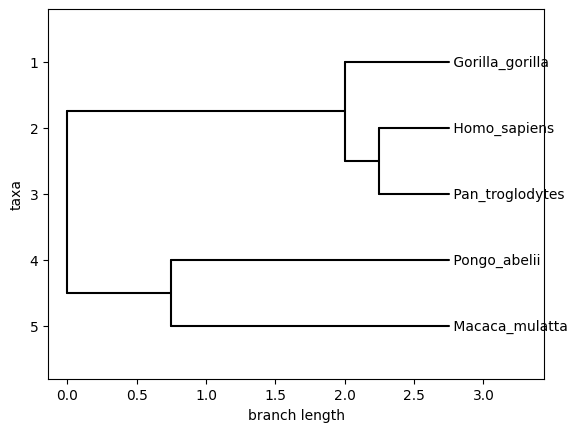

In [2]:
newick = "((Gorilla_gorilla:0.75,(Homo_sapiens:0.5,Pan_troglodytes:0.5):0.25):2.0,(Pongo_abelii:2.0,Macaca_mulatta:2.0):0.75);"
tree = Phylo.read(StringIO(newick), "newick")
Phylo.draw(tree)

Este resultado concuerda bien con la intuición evolutiva: humano y chimpancé aparecen claramente juntos, el gorila se sitúa próximo a este grupo, y, en paralelo, orangután y macaco se agrupan formando el otro gran clado según las distancias del alineamiento.

## Ejercicio 3.2 – Construcción de árboles filogenéticos con distintos métodos

En este apartado se construyen árboles filogenéticos a partir de un mismo alineamiento utilizando criterios diferentes: máxima parsimonia y métodos basados en distancia. El objetivo no es solo obtener árboles, sino comparar cómo cambia la topología según el enfoque empleado y reflexionar sobre las suposiciones implícitas de cada método.

### Carga del archivo FASTA alineado

Todos los métodos filogenéticos parten de un alineamiento múltiple, ya que las comparaciones se realizan posición a posición. En este caso, el archivo FASTA proporcionado ya contiene secuencias alineadas, por lo que puede cargarse directamente.

In [4]:
alignment = AlignIO.read("primates.fasta", "fasta")
print(alignment)
print("Número de secuencias:", len(alignment))
print("Longitud del alineamiento:", alignment.get_alignment_length())

Alignment with 5 rows and 23 columns
ATGCTAGCTAGCTACG--TACG- Homo_sapiens
ATGCTAGCTAGCTACG--TACGA Pan_troglodytes
ATGCTAGCTAG-TACG--TACGA Gorilla_gorilla
ATG-TAGCTAG-TACGCTTACGA Pongo_abelii
ATGATAG-TAG-TATGCTTATGA Macaca_mulatta
Número de secuencias: 5
Longitud del alineamiento: 23


Con este paso, se puede comprobar rápidamente que todas las secuencias tienen la misma longitud y el alineamiento es válido para análisis filogenético.

### 2. Árbol por el método de máxima parsimonia

La máxima parsimonia busca el árbol que minimiza el número total de cambios evolutivos necesarios para explicar el alineamiento. Es un enfoque conceptualmente muy intuitivo: se asume que la evolución tiende a seguir el camino “más simple”, con el menor número de sustituciones posible.

Biopython implementa parsimonia mediante el algoritmo de Fitch, a partir de un árbol inicial.

Primero, se genera un árbol guía inicial (por ejemplo, con UPGMA) para partir de una topología razonable:

In [6]:
calculator = DistanceCalculator("identity")
dm = calculator.get_distance(alignment)

constructor = DistanceTreeConstructor()
starting_tree = constructor.upgma(dm)